In [9]:
%pip install torch torchvision transformers diffusers datasets accelerate
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/captions_train2017.json  
  inflating: dataset/captions_val2017.json  
  inflating: dataset/dataset.json    


In [2]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
import requests
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
discriminator_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
discriminator_model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small")

discriminator_model.classifier = torch.nn.Sequential(torch.nn.Linear(768, 1),
                                                    # torch.nn.Sigmoid())
                                                    torch.nn.Tanh())


teacher_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
teacher_model.scheduler = DPMSolverMultistepScheduler.from_config(teacher_model.scheduler.config)

student_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
student_model.scheduler = DPMSolverMultistepScheduler.from_config(student_model.scheduler.config)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [5]:
# Move models to the chosen device

# discriminator_model = discriminator_model.to(device)
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)
print(discriminator_model)

for param in student_model.parameters():
  param.requires_grad = True


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [6]:
class HingeLoss(torch.nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, output, target):
        return (torch.tensor(target-output))


# Hinge loss for adversarial loss and L2 loss for distillation
adversarial_loss_function = torch.nn.HingeEmbeddingLoss()
adversarial_loss_function.requires_gradient = True
#adversarial_loss_function = torch.nn.BCELoss()
distillation_loss_function = torch.nn.MSELoss()
distillation_loss_function.requires_gradient = True

# Set up the optimizer for the student model
student_optimizer = torch.optim.Adam(student_model.unet.parameters(), lr=0.0001)

# Assuming you have a discriminator model defined
#discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_model_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.0001)

In [10]:
# load the train dataset from folder dataset/captions_train2017.json
dataset = load_dataset('json', data_files='dataset/dataset.json')

train_dataset = dataset["train"]

#split the dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
validation_dataset = dataset["test"]

#further split the train dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset)
print(validation_dataset)
print(test_dataset)

torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'caption'],
    num_rows: 239659
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 29588
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 26629
})


In [11]:
# Function to convert an image from a URL to a PyTorch Tensor
def url_to_tensor(url):

    img = Image.open(requests.get(url, stream=True).raw)

    # Define a transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image
        transforms.ToTensor()           # Convert the image to a PyTorch Tensor
    ])

    # Apply the transform to the image
    img_tensor = transform(img)

    return img_tensor

# Get the first image in the training dataset
img_tensor = url_to_tensor(train_dataset[0]['image'])

# Print the shape of the image tensor
print(img_tensor.shape)


def to_label(pred):

  if pred < 0.5:
    return torch.tensor(-1.0)

  else:
    return torch.tensor(1.0)



torch.Size([3, 256, 256])


In [12]:
def show_tensor_image(pic):

    # Convert the tensor to a PIL Image
    if (isinstance(pic, torch.Tensor)):
        pil_image = transforms.ToPILImage()(pic)

    else:
        pil_image = pic

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

def forward_noise(image, a, s, num_diffusion_steps):

    if (not isinstance(image, torch.Tensor)):
        transform = transforms.ToTensor()
        image = transform(image)

    for i in range(num_diffusion_steps):
        noise = np.random.normal(size=image.shape)  # noise mask
        image = image * a + noise * s

    return image

base_image: A completed puzzle of a fishing village sits on a table.


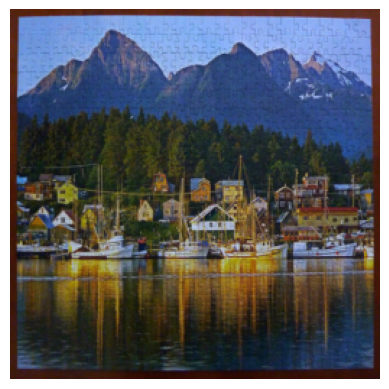

  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.3173, requires_grad=True)
Student image


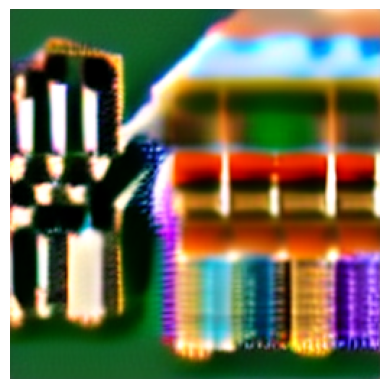

Teacher image


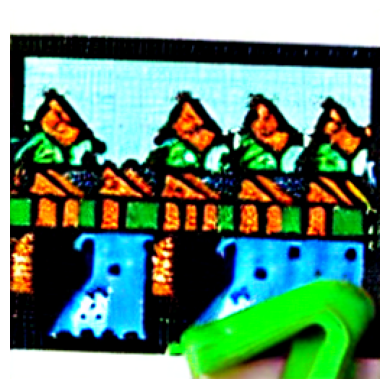

tensor(0.3173, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A street sign sitting by the side of a building.


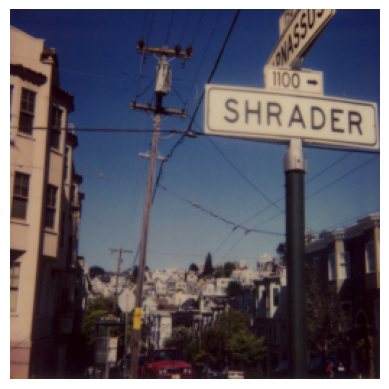

  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.2536, requires_grad=True)
Student image


Teacher image


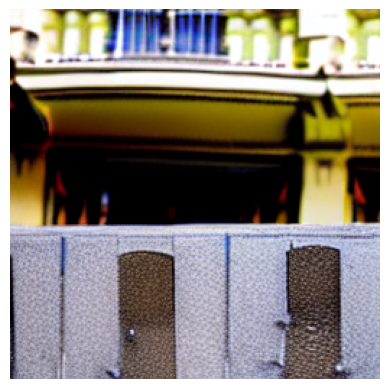

tensor(0.2536, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: The zebra is standing in the field with the other animals in the background.


  0%|          | 0/4 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.2572, requires_grad=True)
Student image


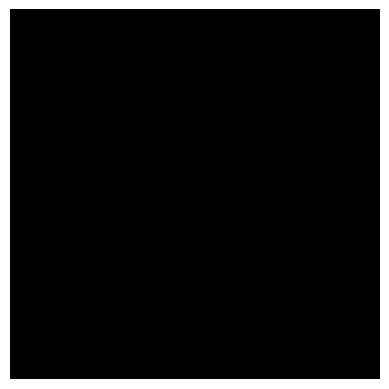

Teacher image


tensor(0.2572, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A long counter holding an assortment of coffee related items.


  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.2655, requires_grad=True)
Student image


Teacher image


tensor(0.2655, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A pizza sitting on top of a pan in an oven.


  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.2389, requires_grad=True)
Student image


Teacher image


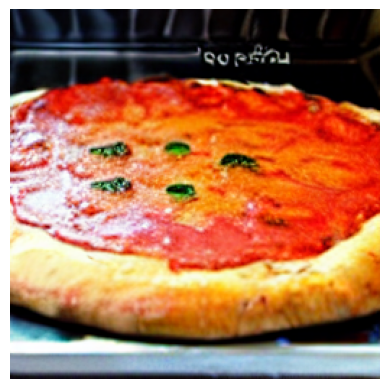

tensor(0.2389, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A man bicycling in the snow with a couple dogs nearby in a forested area.


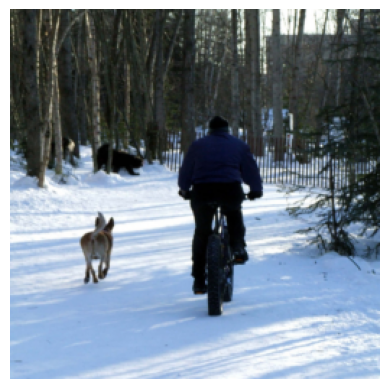

  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.2237, requires_grad=True)
Student image


Teacher image


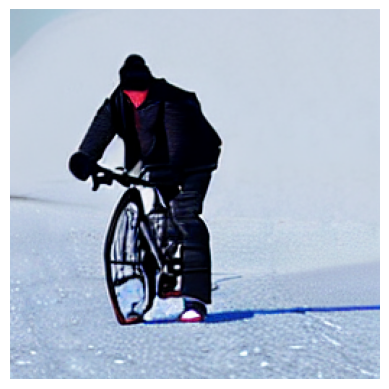

tensor(0.2237, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A photo of a train station with two trains on the tracks.


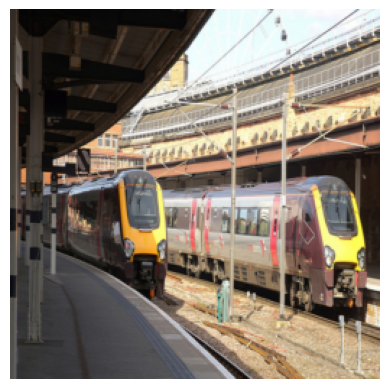

  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.1639, requires_grad=True)
Student image


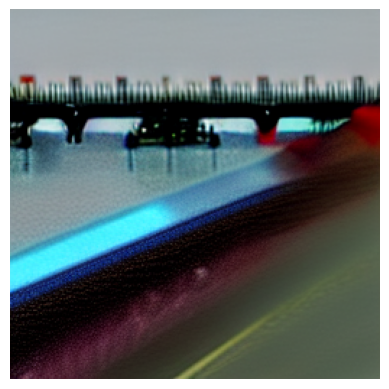

Teacher image


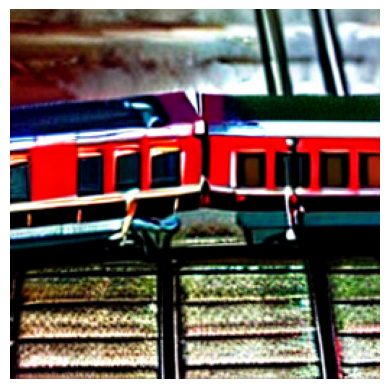

tensor(0.1639, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A motorcyclist is taking a turn on a gravel road. 


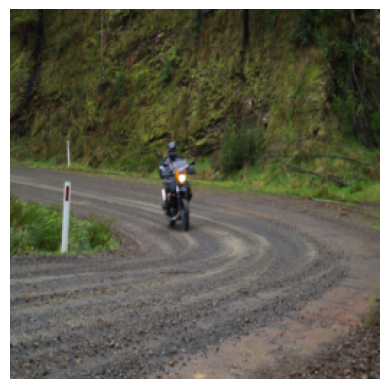

  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.2777, requires_grad=True)
Student image


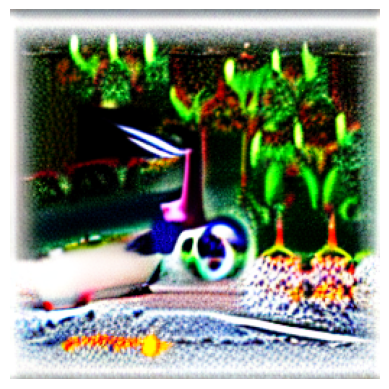

Teacher image


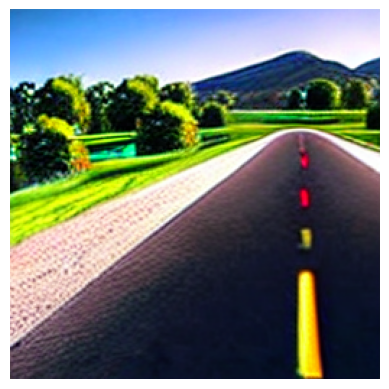

tensor(0.2777, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A sink in a bathroom with items on it.


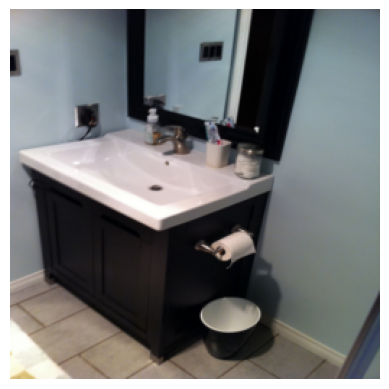

  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.2694, requires_grad=True)
Student image


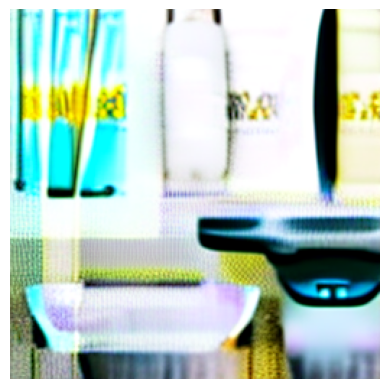

Teacher image


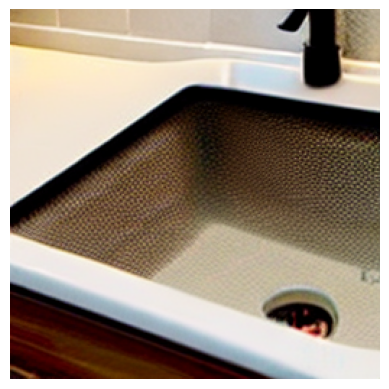

tensor(0.2694, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A red double-decker bus, Number 15, is on the road. 


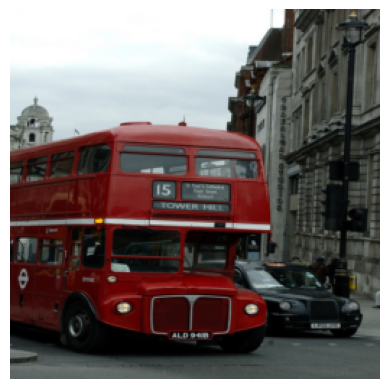

  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.1976, requires_grad=True)
Student image


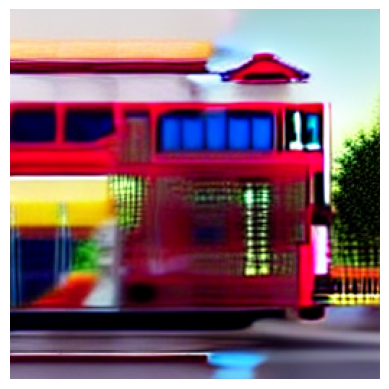

Teacher image


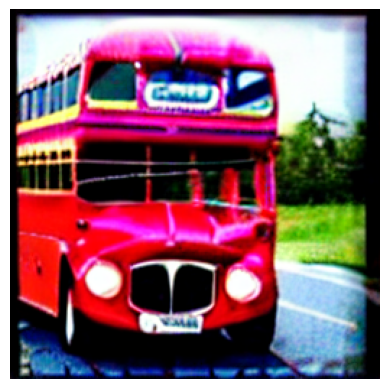

tensor(0.1976, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A red and white airplane is on the runway.


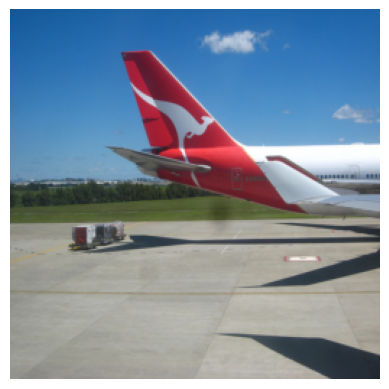

  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>
tensor(0.2283, requires_grad=True)
Student image


Teacher image


tensor(0.2283, requires_grad=True)
tensor([[-1.]], grad_fn=<TanhBackward0>)
base_image: A picture of a couple people skiing in the snow.


  0%|          | 0/4 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


In [ ]:
for epoch in range(100):
    for batch in train_dataset:

        image = url_to_tensor(batch["image"])
        caption = batch["caption"]

        valid = torch.ones(image.size(0), 1)
        fake = torch.zeros(image.size(0), 1)
        real_image = image

        print(f"base_image: {caption}")
        show_tensor_image(real_image)

        # Perform forward diffusion with the specified number of steps
        #print("Noise image")
        diffused_image = forward_noise(image, a = 0.5, s = 0.5, num_diffusion_steps = 50)

        #show_tensor_image(diffused_image)

        #Compute student image
        #print("Student image")
        student_image = student_model(caption, image = diffused_image, height=256, width=256, num_inference_steps=4).images[0]
        print(type(student_image))
        #show_tensor_image(student_image)

        #Perform again forward diffusion with the specified number of steps
       #print("New noised image")
        new_diffused_image = forward_noise(student_image, a = 0.5, s = 0.5, num_diffusion_steps = 50)
        #show_tensor_image(new_diffused_image)

        #Compute teacher image

        teacher_image = teacher_model(caption, image = new_diffused_image, height=256, width=256, num_inference_steps=50).images[0]
        print(type(teacher_image))
        #show_tensor_image(teacher_image)



        real_pred = discriminator_processor(image, return_tensors="pt")
        real_pred = discriminator_model(**real_pred).logits

        #real_pred = to_label(real_pred)
        #print(real_loss)
        real_loss = adversarial_loss_function(real_pred,torch.tensor(1.))

        student_pred = discriminator_processor(student_image, return_tensors="pt")
        student_pred = discriminator_model(**student_pred).logits
        #student_pred = to_label(student_pred)

        student_loss = adversarial_loss_function(student_pred,torch.tensor(1.))

        #print(student_loss)
        adversarial_loss = (real_loss+student_loss)/2



        transform = transforms.ToTensor()

        student_image = transform(student_image)

        teacher_image = transform(teacher_image)

        distillation_loss = distillation_loss_function(student_image, teacher_image)
        distillation_loss.requires_grad = True

        print(distillation_loss)

        print("Student image")
        show_tensor_image(student_image)
        print("Teacher image")
        show_tensor_image(teacher_image)

        print(distillation_loss)

        student_optimizer.zero_grad()
        student_loss.backward(retain_graph=True)
        #distillation_loss.retain_grad()
        distillation_loss.backward()
        student_optimizer.step()

        discriminator_model_optimizer.zero_grad()
        adversarial_loss.backward()  # Retain graph because student model also needs to backpropagate in this iteration
        discriminator_model_optimizer.step()

        # Update student model






        #real_pred = discriminator_model(**real_pred).logits.argmax(-1).item()
        print(real_pred)






